# Geração do classificador de tênis (Nike vs Adidas)

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import seaborn as sns
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

## Carregamento de dados dos datasets.

Separa em treino e teste

In [2]:
from sklearn.model_selection import train_test_split

def datasetLoader(data_dir, batch_size):
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    train_dir = os.path.join(data_dir, "Training")
    train_data = ImageFolder(root=train_dir, transform=transform)

    train_indices, test_indices = train_test_split(
        range(len(train_data)), test_size=0.33, random_state=42
    )

    train_subset = Subset(train_data, train_indices)
    test_subset = Subset(train_data, test_indices)

    training_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_subset, batch_size=batch_size, shuffle=False
    )

    return training_loader, test_loader

Batch size e device

In [3]:
data_dir = "Dataset"
train_loader, test_loader = datasetLoader(data_dir, batch_size=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
print(f"Número total de amostras: {len(test_loader.dataset)+len(train_loader.dataset)}")
print(f"Número de amostras de treinamento: {len(train_loader.dataset)}")
print(f"Número de amostras de teste: {len(test_loader.dataset)}")

Número total de amostras: 564
Número de amostras de treinamento: 377
Número de amostras de teste: 187


 O dropout será ativado entre a camada convolucional final da ResNet50 e a camada linear que produzirá a saída final do modelo. Durante o treinamento, o dropout aleatoriamente "desliga" neurônios, reduzindo a dependência entre eles, o que ajuda a prevenir o overfitting. Dropout ajudou muito para diminuir a valor da função custo de validação.

In [5]:
resnet = torchvision.models.resnet50(weights = True)
resnet.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.6),  # Adicionando dropout com probabilidade 0.5
    torch.nn.Linear(2048, 2)
)
resnet = resnet.to(device)

c:\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Métodos 

### Matriz de confusão

In [6]:
def confusion_matrix(model, loader):
    model.eval()
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                confusion_matrix[labels[i].item()][predicted[i].item()] += 1
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Adidas', 'Nike'], yticklabels=['Adidas', 'Nike'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Label')
    return ax

### Acurácia

In [7]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return corrected * 100 // total

### F1 Score

In [8]:
from sklearn.metrics import f1_score

def calculate_f1_score(model, loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    return f1_score(true_labels, predicted_labels, average='macro')

### ROC AUC métrica

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_roc_auc_score(model, loader, n_classes):
    model.eval()
    true_labels = []
    predicted_probs = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(probs.cpu().numpy())
    true_labels = label_binarize(true_labels, classes=[i for i in range(n_classes)])
    return roc_auc_score(true_labels, predicted_probs, multi_class='ovr')

### Validação

In [10]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
    return val_loss/len(loader)

### Regularização

l1_lambda e l2 lambda são os pesos/intensidade que a regularização aplicará no modelo.

In [11]:
def l1_regularization(model, l1_lambda, device):
    l1_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L1 dos parâmetros e somando-as
        l1_reg += torch.norm(param, 1)
    # Multiplicando pela lambda para obter o termo de regularização L1
    return l1_lambda * l1_reg

In [12]:
def l2_regularization(model, l2_lambda, device):
    l2_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L2 dos parâmetros e somando suas raízes quadradas
        l2_reg += torch.norm(param, 2) ** 2
    # Multiplicando pela lambda e raiz quadrada para obter o termo de regularização L2
    return l2_lambda * torch.sqrt(l2_reg)

### Treinamento

In [13]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(model, trainloader, testloader, optimizer, criterion, epochs, l1_lambda, l2_lambda, device, lr_patience, early_stop_patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    lr_scheduler = ReduceLROnPlateau(optimizer, patience=lr_patience, verbose=True)  # Se a perda de validação não melhorar por x épocas, reduz a taxa de aprendizado em 0,1

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data in tqdm(trainloader):
            images, labels = data
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            l1_reg = l1_regularization(model, l1_lambda, device)    ##  L1 e L2 regularization  ##
            l2_reg = l2_regularization(model, l2_lambda, device)    ##  L1 e L2 regularization  ##     
            loss += l1_reg + l2_reg                                 ##  L1 e L2 regularization  ##
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = validation(model, testloader, criterion)
        lr_scheduler.step(val_loss)                                 ##  Learning Rate Scheduler  ##
        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_loss)
        print(f'Epoch: {epoch+1} | Train Loss: {train_losses[-1]} | Val Loss: {val_loss}')

        if val_loss < best_val_loss:                                ##  Early Stopping  ##
            best_val_loss = val_loss                                
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stop_patience:
                print(f'Parada antecipada na época {epoch+1}, pois a loss na validação não apresentou melhora.')
                break
        
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

## Registro de evoluções nos modelos
- 1º modelo era treinado com apenas 3 épocas e com learning rate de 0,001. **Acurácia de 58%**.
- 2º modelo subimos o número de épocas para 30 (número baseado nos modelos analisados da referência 1) e ajustamos o learning rate para 0,0001. **Acurácia de 88%**.
- 3º modelo inserimos regularização L1 e L2 com peso da regularização de 0,01. **Acurácia caiu para 64%**
- 4º modelo ajustamos os parâmetros de pesos da regularização L1 e L2 para de 0,00001. **Acurácia de 88%**
- 5º modelo feito idêntico ao anterior, com learning rate de 0.0001, regularização l1 l2 com pesos de 0.0001, 30 épocas mas com adição de data augmentation. **Acurácia de 84%**
- 6º modelo feito igual ao quarto, porém com pesos de regularização de 10-5 e sem técnica de data augmentation. **Acurácia de 92%**
- 7º modelo adicionado a técnica de dropout, com hiperparâmetro de 0.6, early stop com paciência de 5, reduzir o learning em platô com paciência de 3 iniciando com 0.0001 de LR e pesos de regularização em 0.001 (L1) e 0.01 (L2). **Acurácia de 95%**

Referências:  
1 - https://www.kaggle.com/datasets/ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset/code

Hiperparâmetros do treinamento:

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
l1_lambda = 0.001
l2_lambda = 0.01
epochs = 60 
lr_patience = 3
early_stop_patience = 5

## Treinamento

 28%|██▊       | 9/32 [00:02<00:04,  5.44it/s]c:\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 32/32 [00:06<00:00,  4.85it/s]


Epoch: 1 | Train Loss: 253.51613855361938 | Val Loss: 0.24044641945511103


100%|██████████| 32/32 [00:05<00:00,  6.23it/s]


Epoch: 2 | Train Loss: 209.30436277389526 | Val Loss: 0.250575098907575


100%|██████████| 32/32 [00:05<00:00,  6.28it/s]


Epoch: 3 | Train Loss: 171.29841423034668 | Val Loss: 0.14259204862173647


100%|██████████| 32/32 [00:05<00:00,  6.23it/s]


Epoch: 4 | Train Loss: 139.86001896858215 | Val Loss: 0.23846037941984832


100%|██████████| 32/32 [00:05<00:00,  6.14it/s]


Epoch: 5 | Train Loss: 115.54568457603455 | Val Loss: 0.270912469830364


100%|██████████| 32/32 [00:05<00:00,  6.10it/s]


Epoch: 6 | Train Loss: 97.87586379051208 | Val Loss: 0.27286151237785816


100%|██████████| 32/32 [00:05<00:00,  5.96it/s]


Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 7 | Train Loss: 83.36560821533203 | Val Loss: 0.18652196135371923


100%|██████████| 32/32 [00:05<00:00,  6.06it/s]


Epoch: 8 | Train Loss: 76.05618095397949 | Val Loss: 0.14649723097682
Parada antecipada na época 8, pois a loss na validação não apresentou melhora.


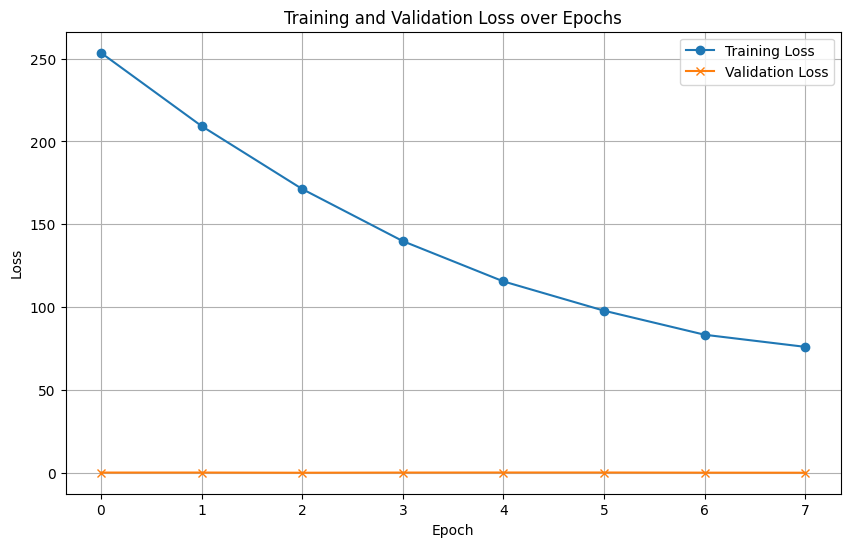

In [16]:
train(resnet, train_loader, test_loader, optimizer, criterion, epochs=epochs, l1_lambda=l1_lambda, l2_lambda=l2_lambda, device=device, lr_patience=lr_patience, early_stop_patience=early_stop_patience)

In [17]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Métricas de avaliação

### Validação

A rede atinge: 95% de acurácia
A rede atinge: 95.18% de f1 Score
A rede atinge: 98.83% de ROC AUC Score


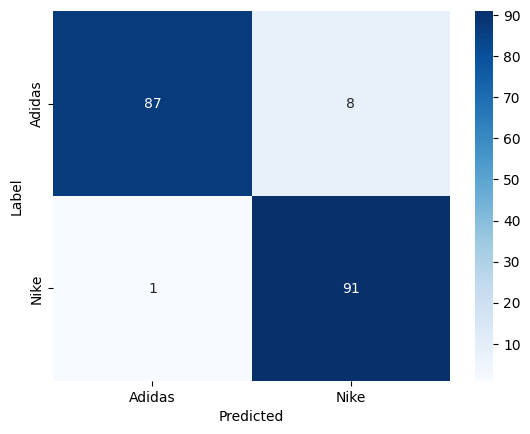

In [18]:
print(f'A rede atinge: {accuracy(resnet, test_loader)}% de acurácia')
print(f'A rede atinge: {round(calculate_f1_score(resnet, test_loader)*100,2)}% de f1 Score')
print(f'A rede atinge: {round(calculate_roc_auc_score(resnet, test_loader, 50)*100,2)}% de ROC AUC Score')
conf_mat = confusion_matrix(resnet, test_loader)

### Treino

c:\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


A rede atinge: 100% de acurácia
A rede atinge: 100.0% de recall


c:\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


A rede atinge: 100.0% de ROC AUC Score


c:\Python310\lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


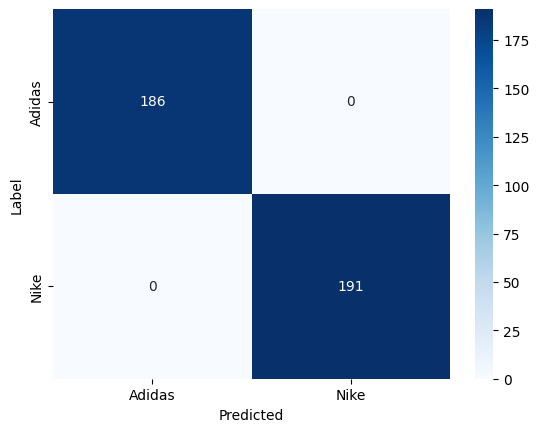

In [19]:
print(f'A rede atinge: {accuracy(resnet, train_loader)}% de acurácia')
print(f'A rede atinge: {round(calculate_f1_score(resnet, train_loader)*100,2)}% de recall')
print(f'A rede atinge: {round(calculate_roc_auc_score(resnet, train_loader, 50)*100,2)}% de ROC AUC Score')
conf_mat = confusion_matrix(resnet, train_loader)

In [20]:
torch.save(resnet.state_dict(), 'model.pth')

# Utilização do classificador de tênis (Nike vs Adidas)

## Usabilidade de webcam

In [ ]:
import cv2

cap = cv2.VideoCapture(0)

img_counter = 0

while True:
    ret, frame = cap.read()
    cv2.imshow('Webcam', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    elif cv2.waitKey(1) & 0xFF == ord('e'):
            img_name = "WebcamImages/print_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

cap.release()
cv2.destroyAllWindows()

### Predição

In [ ]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Adidas' if result == 0 else 'Nike'

### Predição das classes da webcam

In [ ]:
cnn = torch.load('model.pth')
resnet.load_state_dict(cnn)
from PIL import Image
for filename in os.listdir('WebcamImages'):
    if filename.endswith(".png"):
        x = Image.open('WebcamImages/' + filename).convert('RGB')
        x = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])(x)
        print(f'Image: {filename} | Resnet Prediction: {predict(resnet, x)}')